# Update Motor Imagery Decoder
Use this clean notebook to load a pre-existing model and associated data, load new data, and re-train the decoder using all the data deemed appropriate for inclusion.

Nile Wilson 2019.01.16-23

In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.neural_network import MLPClassifier
from matplotlib import pyplot as plt
from scipy.fftpack import fft, ifft
from scipy import signal
from mne.filter import filter_data

import scipy.signal as scisig
import numpy as np
import pandas as pd
import datetime
import pickle
import glob
import csv
import mne

## Function Definitions

In [2]:
def LoadEEGData(filename, EEGdevice):
    """ This function converts a single .easy file (from NIC2) to an easy-to-use dataframe.
    Uses both the .easy file and .info file (containing metadata)
    
    ---- Input ----
    filename: string containing the .easy filepath
    
    ---- Output ----
    df: dataframe containing all the EEG, accelerometer, and event marker data
    fs: sampling rate for the EEG data (Hz)
    fs_accel: sampling rate for the accelerometer data (Hz)
    
    """
    if EEGdevice == 7:
        x = 1
    elif EEGdevice == 8:
        # Read in the .easy file
        df = pd.read_csv(filename, delimiter='\t', header=None)

        # Get metadata from the .info file
        fname = filename[:-5] + '.info'
        with open(fname) as f:
            content = f.readlines()
        content = [x.strip() for x in content]

        # Get the channel names
        channel_info = [x for x in content if 'Channel ' in x]
        channel_names = []
        for ch in range(len(channel_info)):
            channel_names.append(channel_info[ch].split(': ')[1])

        channel_names.append('X')
        channel_names.append('Y')
        channel_names.append('Z')
        channel_names.append('STI 014')
        channel_names.append('DateTime')

        # Get sampling rates
        sampling_rates = [x for x in content if 'sampling rate: ' in x]
        fs_all = []
        for freq in range(len(sampling_rates)):
            fs_all.append(float(sampling_rates[freq].split(': ')[1].split(' ')[0]))

        # Store sampling rates
        fs = fs_all[0]
        fs_accel = fs_all[1]

        # Assign the column names
        df.columns = channel_names
    
    # Return dataframe and sampling rates
    return df, fs, fs_accel

In [3]:
def LoadBehavioralData(filename_behavioral):
    """
    This function loads behavioral data for the motor screening task and formats it to use in this script
    """
    behavioralData = pd.read_csv(filename_behavioral, ',')
    behavioralData = behavioralData.transpose()
    behavioralHeader = behavioralData.iloc[0]
    behavioralData = behavioralData.iloc[2:]
    behavioralData.columns = behavioralHeader
    
    return behavioralData

In [4]:
def SyncTriggerPulses(EEGdata, EEGdevice, fs, behavioralData):
    """
    This function returns the indices for events of interest
    """
    
    if EEGdevice == 7:
        print('Put code here')
    elif EEGdevice == 8:
        # Store where the values in trigger are equal to 8 (the audio trigger input channel number)
        index_trigger = np.where(EEGdata['STI 014']!=0)
        index_trigger = index_trigger[0]
        
        # Check number of trials
        num_of_trials = behavioralData.shape[0]
        if num_of_trials > len(index_trigger):
            num_of_trials = num_of_trials - 1
            num_trials_removed = 1
        else:
            num_trials_removed = 0
        
        trialLength = int(behavioralData['trialLength'][0])

        # Get trial timing
        t_trial_start = list()
        t_trial_end = list()

        # Creating lists of all trigger start and end locations
        for i in range(0,num_of_trials):
            t_trial_start.append(index_trigger[i])
            t_trial_end.append(index_trigger[i] + int(trialLength*fs))

        # Save rest period epochs as well as trials for comparison
        t_rest_start = list()
        t_rest_end = list()

        for i in range(num_of_trials-1):
            t_rest_start.append(t_trial_end[i])
            t_rest_end.append(t_trial_start[i+1])
    
    return num_of_trials, t_trial_start, t_trial_end, t_rest_start, t_rest_end

In [5]:
def EpochData(EEGdata, t_trial_start, t_trial_end):
    """
    This function epochs the data
    """
    
    if EEGdevice == 7:
        channels = EEGdata.columns[1:8]
    elif EEGdevice == 8:
        channels = EEGdata.columns[0:7]
    
    epochs = []
    epochs_norm = []

    for trial in range(0,len(t_trial_start)):
        t_start = t_trial_start[trial]
        t_end = t_trial_end[trial]

        # Baseline
        if trial == 0:
            tb_start = t_trial_start[trial] - np.round(1.5*fs)
            tb_end = t_trial_start[trial]
        else:
            tb_start = t_trial_end[trial-1]
            tb_end = t_trial_start[trial]
            
        baseline = EEGdata.loc[tb_start:tb_end][channels]
        
        # Store epoch
        tmp = (EEGdata.loc[t_start:t_end][channels] - np.mean(baseline))/np.std(baseline)
        epochs_norm.append(tmp)
        epochs.append(EEGdata.loc[t_start:t_end][channels])
    
    return epochs, epochs_norm

In [6]:
def OrganizeTrials(behavioralData):
    """
    Organizes trials
    """
    
    # Create lists for each trial type
    trialL = list()
    trialR = list()
    i = 0

    for letter in behavioralData['trialType'][1:]:
        if letter == 'L':
            trialL.append(i)
        elif letter == 'R':
            trialR.append(i)
        i += 1
    
    # Create a single list that includes which trial is which (L = 0, R = 1)
    trial_type = list()
    i = 0

    for letter in behavioralData['trialType'][1:]:
        if letter == 'L':
            trial_type.append(0)
        elif letter == 'R':
            trial_type.append(1)
        i += 1

    return trial_type, trialL, trialR

In [7]:
def ExtractFeatures(epochs, num_of_trials, channelsToUse, ds_factor):
    """
    Extract signal features of interest
    """
    
    # Get the summed delta power for each trial
    alpha_power = dict.fromkeys(channelsToUse)
    beta_power = dict.fromkeys(channelsToUse)
    ds_f = ds_factor # downsampling factor

    for chanOfInt in channelsToUse:
        tmp_alpha = list()
        tmp_beta = list()

        for trial in range(0, num_of_trials):
            f, Pxx_den = signal.welch(signal.decimate(epochs[trial][chanOfInt],ds_f), fs/ds_f, scaling='spectrum')
            alpha_idx = np.where(np.logical_and(np.round(f) > 8, np.round(f) <= 12))
            tmp_alpha.append(np.sum(Pxx_den[alpha_idx]))

            beta_idx = np.where(np.logical_and(np.round(f) > 13, np.round(f) <= 30))
            tmp_beta.append(np.sum(Pxx_den[beta_idx]))

        alpha_power[chanOfInt] = tmp_alpha
        beta_power[chanOfInt] = tmp_beta
    
    return alpha_power, beta_power

In [8]:
def ExtractErrorFeatures(epochs, num_of_trials, error_template, correct_template, featureType):
    """
    Extract signal features of interest
    featureType:    'template' or 'frequency'. 'template' returns features based on the template projection values
                    for individual epochs with the error and correct templates. 'frequency' returns features that
                    are just delta and theta power for each channel for the epochs
    """
    
    if featureType in ['template','Template','TEMPLATE','t','T','projection','Projection','PROJECTION','p','P']:
        # template_projection[chanOfInt] will have two columns
        # col 1: how well the trial signal matches with the error signal template
        # col 2: how well the trial signal matches with the correct signal template
        projections_all = dict()
        channelsToUse = error_template.keys()

        for chanOfInt in channelsToUse:
            projections = np.zeros([2, num_of_trials])
            for trial in range(0, num_of_trials):
                # Individual epoch (normalized)
                tmp = epochs_norm[trial][chanOfInt]
                a = tmp

                # Template waveform for error (normalized)
                tmp0 = error_template[chanOfInt]
                tmp_norm = (tmp0 - np.mean(tmp0))/np.std(tmp0)
                b = tmp_norm

                # Template waveform for correct (normalized)
                tmp = correct_template[chanOfInt]
                tmp_norm = (tmp - np.mean(tmp0))/np.std(tmp0)
                c = tmp_norm

                # Store sum of convolutions

                projections[0][trial] = np.sum(np.convolve(a,b,'same'))
                projections[1][trial] = np.sum(np.convolve(a,c,'same'))

            projections_all[chanOfInt] = projections
        
        # Organize the features
        channels = list(projections_all.keys())
        num_of_features = np.shape(projections_all['F3'])[0] * len(channels)
        channels_full = list(projections_all.keys()) * 2
        num_of_trials = np.shape(projections_all['F3'])[1]

        features = np.zeros([num_of_features, num_of_trials])

        for trial in range(0, num_of_trials):
            # Error trials are 0 to num_of_features//2, and correct trials are num_of_features//2 to num_of_features
            for feature in range(0, num_of_features):
                features[feature, trial] = projections_all[channels_full[feature]][0][trial]
            
    elif featureType in ['frequency','Frequency','FREQUENCY','f','F']:
        channelsToUse = error_template.keys()
        delta_power = dict.fromkeys(channelsToUse)
        theta_power = dict.fromkeys(channelsToUse)
        ds_f = 1 # downsampling factor

        for chanOfInt in channelsToUse:
            tmp_delta = list()
            tmp_theta = list()

            for trial in range(0, num_of_trials):
                f, Pxx_den = signal.welch(signal.decimate(epochs_norm[trial][chanOfInt],ds_f), fs/ds_f, scaling='spectrum')
                delta_idx = np.where(np.round(f) <= 4)
                tmp_delta.append(np.sum(Pxx_den[delta_idx]))

                theta_idx = np.where(np.logical_and(np.round(f) > 4, np.round(f) <= 7))
                tmp_theta.append(np.sum(Pxx_den[theta_idx]))

            delta_power[chanOfInt] = tmp_delta
            theta_power[chanOfInt] = tmp_theta
            
        # Organize the features
        num_of_examples = len(delta_power['F3'])
        num_of_features = len(delta_power.keys()) + len(theta_power.keys()) 
        features = np.zeros([num_of_features, num_of_examples])

        # Get all channels in one list to loop through
        feature_channels = np.concatenate([np.asarray(list(delta_power.keys())),np.asarray(list(theta_power.keys()))])

        for i in range(0, num_of_examples):
            for j in range(0, num_of_features//2):
                features[j, i] = delta_power[feature_channels[j]][i]
            for j in range(num_of_features//2, num_of_features):
                features[j, i] = theta_power[feature_channels[j]][i]

    
    return features

In [75]:
def EpochErrorData(EEGdata, fs, EEGdevice, t_trial_start):
    """
    This function epochs the data
    """
    if EEGdevice == 7:
        channels = EEGdata.columns[1:8]
    elif EEGdevice == 8:
        channels = EEGdata.columns[0:7]

    epochs = []

    for trial in range(0,len(t_trial_start)):
        t_start = t_trial_start[trial] - np.round(0  * fs)
        t_end = t_trial_start[trial] + np.round(0.600 * fs)

        # Baseline
        tb_start = t_trial_start[trial] - np.round(0.700 * fs)
        tb_end = t_trial_start[trial] - np.round(0.100 * fs)
        baseline = EEGdata.loc[tb_start:tb_end][channels]

        # Store epoch
        tmp = (EEGdata.loc[t_start:t_end][channels] - np.mean(baseline))/np.std(baseline)
        epochs.append(tmp)
    
    return epochs

In [76]:
def ConfidenceScoreExamples(X, y, EEGdata, EEGdevice, fs, num_of_trials, t_trial_start, t_trial_end, trial_type):
    """
    This is the function that does the confidence scoring based on error detection and attention
    """
    # Load the error detection model and see what featureType it used (frequency or template projections)
    models = glob.glob(subjID + '_Error_classifier_*')
    model_file = models[-1] # load the most recent model
    clf_error = pickle.load(open(model_file, 'rb'))
    print(model_file)
    print(clf_error)

    models_data_list = glob.glob(subjID + '_data_for_Error_classifier_*')
    models_data = models_data_list[-1] # load the most recent model
    loaded_data = np.load(models_data)
    featureType = loaded_data['featureType']
    
    # Load templates if applicable
    error_template = loaded_data['error_template'].tolist()
    correct_template = loaded_data['correct_template'].tolist()

    # Create new epochs for error detection
    epochs = EpochErrorData(EEGdata, fs, EEGdevice, t_trial_start)
    features = ExtractErrorFeatures(epochs, num_of_trials, error_template, correct_template, featureType)
    features = features.T
    
    # Detect error
    preds_error = clf_error.predict(features) # is there an ErrP or not? 1 = yes ErrP, 0 = no ErrP
    preds_error_proba = clf_error.predict_proba(features) # what is the prob of there being an ErrP?
    
    # Confidence in the prediction of error
    prob_error = (preds_error_proba[:,1] * preds_error)

    # Confidence in the prediction of no error
    prob_no_error = preds_error_proba[:,0] * (1-preds_error)

    # Confidence the epoch is correct
    CS = 1 - (prob_error + prob_no_error)
    
    """
    Also return true label stuff
    """
    # Also return true label scores
    # Load the error detection model and see what featureType it used (frequency or template projections)
    models = glob.glob(subjID + '_MI_classifier_*')
    model_file = models[-1] # load the most recent model
    clf_MI = pickle.load(open(model_file, 'rb'))

    preds_MI = clf_MI.predict(X)
    
    # trial_type 0 is L, trial_type 1 is R, and TL 1 is high confidence (correct), and TL 0 is low confidence (error)
    TL = list()
    for trial in range(0, len(trial_type)):
        if trial_type[trial] == 0:
            if preds_MI[trial] == 0:
                TL.append(1)
            else:
                TL.append(0)
        elif trial_type[trial] == 1:
            if preds_MI[trial] == 1:
                TL.append(1)
            else:
                TL.append(0)

    return CS, TL, preds_MI, preds_error, preds_error_proba, epochs, features, clf_error

In [50]:
def RetrainDecoder(clf, CS, threshold, X_old, y_old, X_new, y_new, adaptationType):
    """
    Retrains the decoder on ALL the previous data plus what you decided to add in with high confidence scores
    
    clf: your preloaded model (most recent version)
    CS: confidence scores (if true labels, use TL instead of CS)
    X_old: your preloaded model data (X)
    y_old: your preloaded model data (y)
    X_new: your new motor features
    y_new: your new labels
    """
    # Concatenate old X and y with new X and y that have a high enough confidence score
    aboveThreshold = np.where(CS>threshold)
    
    X = np.concatenate((X_old, X_new[aboveThreshold]), axis=0)
    y = np.concatenate((y_old, np.asarray(y_new)[aboveThreshold]), axis=0)
    
    # preprocess dataset, split into training and test part
    args = np.arange(len(X))
    np.random.shuffle(args)
    X = [X[i] for i in args]
    y = [y[i] for i in args]
    X = StandardScaler().fit_transform(X)

    # Fit the model
    clf.fit(X,y)
    
    """
    # Split into train and test for evaluation
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
    grid.fit(X_train, y_train)

    # Fit the model
    clf = grid.best_estimator_
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)

    print(grid.best_estimator_)
    print('-----------')
    print('score: ' + str(score))
    print(confusion_matrix(y_test, clf.predict(X_test)))
    print('-----------')
    """
    
    return clf, X, y

In [51]:
def SaveDecoderAndData(clf, X, y, subjID):
    """
    Save the decoder and the data it was trained/tested on
    """
    time_to_save = datetime.datetime.now().isoformat()
    time_to_save = time_to_save.replace('T','-')
    time_to_save = time_to_save.replace(':','-')
    
    model = clf
    model_file = subjID + '_MI_classifier_' + time_to_save[:19] + '.sav'
    pickle.dump(model, open(model_file, 'wb'))
    
    filepath_export_data = subjID + '_data_for_MI_classifier_' + time_to_save[:19] + '.npz'
    np.savez_compressed(filepath_export_data, X=X, y=y)

## Variables to Set

In [13]:
subjID = 'katie'
EEGdevice = 8 # 7 for DSI-7, 8 for Enobio
filename_eeg = '../data/Enobio/20190118142722_katie_Motor_Screening.easy'
filename_behavioral = '../data/Enobio/katie_Motor_Screening_R1.csv'

## Code to Run

### Run automatically

In [14]:
# Load EEG data
EEGdata, fs, fs_accel = LoadEEGData(filename_eeg, EEGdevice)

# Load behavioral data
behavioralData = LoadBehavioralData(filename_behavioral)

# Sync up trigger pulses
num_of_trials, t_trial_start, t_trial_end, t_rest_start, t_rest_end = SyncTriggerPulses(EEGdata, EEGdevice, fs, behavioralData)

### Run manually
Need to manually inspect and select ICs for artifact removal in the most recent EEG data

In [59]:
# Clean the data
EEGdata_orig = EEGdata.copy()
lf = 1
hf = 40

if EEGdevice == 7:
    channels = EEGdata.columns[1:8]
elif EEGdevice == 8:
    channels = EEGdata.columns[0:7]

# Format our data into an mne-friendly format
ch_types = ['eeg']*len(channels)
info = mne.create_info(ch_names=list(channels), sfreq=fs, ch_types=ch_types)
rawData = EEGdata[channels].values
rawData = np.transpose(rawData)
raw = mne.io.array.RawArray(rawData, info)
raw.set_montage(mne.channels.read_montage(kind='standard_1020'))
raw.filter(l_freq=lf, h_freq=hf)

Creating RawArray with float64 data, n_channels=7, n_times=300686
    Range : 0 ... 300685 =      0.000 ...   601.370 secs
Ready.
Setting up band-pass filter from 1 - 40 Hz
l_trans_bandwidth chosen to be 1.0 Hz
h_trans_bandwidth chosen to be 10.0 Hz
Filter length of 1651 samples (3.302 sec) selected


<RawArray  |  None, n_channels x n_times : 7 x 300686 (601.4 sec), ~16.1 MB, data loaded>

In [60]:
# Make a copy of the original data just in case
EEGdata[channels] = raw.get_data().T

### Run automatically

In [61]:
# Epoch the data
epochs, epochs_norm = EpochData(EEGdata, t_trial_start, t_trial_end)

# Organize trial types
trial_type, trialL, trialR = OrganizeTrials(behavioralData)

# Get signal features
alpha_power, beta_power = ExtractFeatures(epochs_norm, num_of_trials, ['C3','C4'], 1)
motor_features = [alpha_power['C3'], alpha_power['C4'], beta_power['C3'], beta_power['C4']]
motor_features = np.transpose(motor_features)

C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


In [77]:
# Choose which examples to keep through confidence scoring
X_new = motor_features
y_new = trial_type
CS, TL, preds_MI, preds_error, preds_error_proba, epochs, features, clf_error = ConfidenceScoreExamples(X_new, y_new, EEGdata, EEGdevice, fs, num_of_trials, t_trial_start, t_trial_end, trial_type)

# Load latest model and its associated data
models = glob.glob(subjID + '_MI_classifier_*')
model_file = models[-1] # load the most recent model
loaded_model = pickle.load(open(model_file, 'rb'))

models_data_list = glob.glob(subjID + '_data_for_MI_classifier_*')
models_data = models_data_list[-1] # load the most recent model
loaded_data = np.load(models_data)
X = loaded_data['X']
y = loaded_data['y']

katie_Error_classifier_2019-01-23-15-33-11.sav
MLPClassifier(activation='relu', alpha=0.01, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=1, shuffle=True, solver='lbfgs', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)


C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nilew\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


# FIGURE OUT WHAT"S WRONG

Okay, so no error is being detected... let's check to see why (there should definitely be more)

For the error prediction model: 0 = no error, 1 = error

In [78]:
np.shape(epochs[0]['F3'])

(301,)

In [92]:
epochs[0]['F3']

13678   -0.208802
13679   -0.146485
13680   -0.102677
13681   -0.070077
13682   -0.042470
13683   -0.016978
13684    0.004985
13685    0.018331
13686    0.016315
13687   -0.006645
13688   -0.052203
13689   -0.116280
13690   -0.188891
13691   -0.255852
13692   -0.302071
13693   -0.315657
13694   -0.291725
13695   -0.234810
13696   -0.159014
13697   -0.085618
13698   -0.038497
13699   -0.038348
13700   -0.097101
13701   -0.213977
13702   -0.374341
13703   -0.551844
13704   -0.713586
13705   -0.827212
13706   -0.868347
13707   -0.826593
           ...   
13949    0.358804
13950    0.338847
13951    0.294285
13952    0.228951
13953    0.151784
13954    0.074698
13955    0.009970
13956   -0.032197
13957   -0.045380
13958   -0.027602
13959    0.019031
13960    0.089451
13961    0.177080
13962    0.275152
13963    0.377578
13964    0.479221
13965    0.575665
13966    0.662730
13967    0.736049
13968    0.790988
13969    0.823032
13970    0.828594
13971    0.806039
13972    0.756605
13973    0

In [79]:
np.shape(features)

(99, 14)

In [80]:
features

array([[0.15457104, 0.15133883, 0.37193582, ..., 0.08374889, 0.11898114,
        0.09169394],
       [0.18203207, 0.09361725, 0.26839613, ..., 0.09815699, 0.12498778,
        0.14050123],
       [0.93490206, 0.81593561, 0.55759509, ..., 0.15763527, 0.07292388,
        0.08443781],
       ...,
       [0.50038876, 0.44174103, 0.35605692, ..., 0.1270326 , 0.13856926,
        0.18048714],
       [1.23524399, 1.40243222, 0.62318867, ..., 0.24158262, 0.17725921,
        0.1448216 ],
       [0.2981541 , 0.39170945, 0.30452899, ..., 0.09953951, 0.04770082,
        0.09639542]])

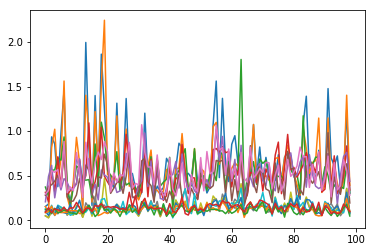

In [81]:
plt.figure()
plt.plot(features)
plt.show()

In [82]:
np.shape(features)

(99, 14)

In [95]:
# Number of errors (remember TL=1 is a correct epoch, TL=0 is an error epoch)
num_of_errors = len(TL)-sum(TL)
num_of_correct = sum(TL)

print('Number of error epochs: ' + str(num_of_errors))
print('Number of correct epochs: ' + str(num_of_correct))

Number of error epochs: 49
Number of correct epochs: 50


In [83]:
preds_error

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [84]:
models_data_list = glob.glob(subjID + '_data_for_Error_classifier_*')
models_data = models_data_list[-1] # load the most recent model
loaded_data = np.load(models_data)
X = loaded_data['X']
y = loaded_data['y']

In [85]:
X

array([[-0.28796317, -0.2316712 ,  0.13739112, ..., -0.69605527,
        -0.73011494, -0.79552306],
       [-0.36181703, -0.34439478,  0.00619753, ..., -0.3162374 ,
        -0.50576305,  0.54281772],
       [ 0.01921101, -0.09000717, -0.06848089, ..., -0.3634849 ,
        -0.71088126, -0.77649132],
       ...,
       [ 2.51137274,  3.89279931,  3.40263579, ..., -0.28481365,
         0.37549171,  1.74028435],
       [-0.50667422, -0.47750756, -0.62730799, ..., -0.71609838,
         0.06719429, -0.69490812],
       [-0.38541302, -0.32534272, -0.30617844, ..., -0.38652395,
        -0.53600783, -0.6371749 ]])

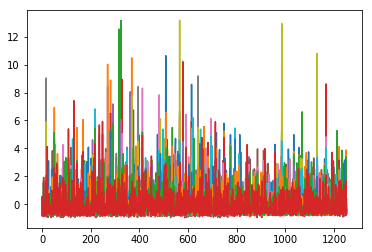

In [86]:
plt.figure()
plt.plot(X)
plt.show()

In [ ]:
preds_error

In [ ]:
preds_error_proba

In [ ]:
np.shape(CS)

In [ ]:
# Confidence in the prediction of error
prob_error = (preds_error_proba[:,1] * preds_error)

# Confidence in the prediction of no error
prob_no_error = preds_error_proba[:,1] * (1-preds_error)

# Confidence the epoch is correct
CS = 1 - (prob_error + prob_no_error)
CS

In [ ]:
CS

In [ ]:
preds_error

In [ ]:
(preds_error_proba[:,1] * preds_error)

In [ ]:
# Confidence in the prediction of error
prob_error = (preds_error_proba[:,1] * preds_error)

# Confidence in the prediction of no error
prob_no_error = preds_error_proba[:,0] * (1-preds_error)

# Confidence the epoch is correct
CS = 1 - (prob_error + prob_no_error)

In [ ]:
plt.figure()
plt.plot(CS,'o')
plt.show()

In [ ]:
tmp = np.where(CS>0.7)
np.shape(tmp)

In [ ]:
np.shape(motor_features)

In [ ]:
np.shape(X)

In [88]:
if EEGdevice == 7:
    channels = EEGdata.columns[1:8]
elif EEGdevice == 8:
    channels = EEGdata.columns[0:7]

epochs_norm = []

for trial in range(0,len(t_trial_start)):
    t_start = np.round(t_trial_start[trial] - (0  * fs))
    t_end = np.round(t_trial_start[trial] + (0.600 * fs))

    # Baseline
    tb_start = np.round(t_trial_start[trial] - (0.700 * fs))
    tb_end = np.round(t_trial_start[trial] - (0.100 * fs))
    baseline = EEGdata.loc[tb_start:tb_end][channels]

    # Store epoch
    tmp = (EEGdata.loc[t_start:t_end][channels] - np.mean(baseline))/np.std(baseline)
    epochs_norm.append(tmp)

In [89]:
np.shape(epochs[0]['F3'])

(301,)

In [91]:
epochs[0]['F3']

13678   -0.208802
13679   -0.146485
13680   -0.102677
13681   -0.070077
13682   -0.042470
13683   -0.016978
13684    0.004985
13685    0.018331
13686    0.016315
13687   -0.006645
13688   -0.052203
13689   -0.116280
13690   -0.188891
13691   -0.255852
13692   -0.302071
13693   -0.315657
13694   -0.291725
13695   -0.234810
13696   -0.159014
13697   -0.085618
13698   -0.038497
13699   -0.038348
13700   -0.097101
13701   -0.213977
13702   -0.374341
13703   -0.551844
13704   -0.713586
13705   -0.827212
13706   -0.868347
13707   -0.826593
           ...   
13949    0.358804
13950    0.338847
13951    0.294285
13952    0.228951
13953    0.151784
13954    0.074698
13955    0.009970
13956   -0.032197
13957   -0.045380
13958   -0.027602
13959    0.019031
13960    0.089451
13961    0.177080
13962    0.275152
13963    0.377578
13964    0.479221
13965    0.575665
13966    0.662730
13967    0.736049
13968    0.790988
13969    0.823032
13970    0.828594
13971    0.806039
13972    0.756605
13973    0

In [ ]:
CS

In [ ]:
preds_error_proba[:,1] * preds_error

In [ ]:
tmp = CS[:,1] * preds_error
plt.figure()
plt.plot(preds_error,'o')
plt.show()

In [ ]:
np.shape(CS)

# CONTINUE
Final bit of code

In [ ]:
# Save
SaveDecoderAndData(clf, X, y, subjID, adaptationType)

In [ ]:
# Retrain
adaptationType = 'CS' # either 'CS' for confidence score, or 'TL' for true label
clf, X, y = RetrainDecoder(loaded_model, CS, 0.7, X, y, motor_features, trial_type, adaptationType)